In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse551/Youtube_communities.txt
/kaggle/input/cse551/roadNet_Texas.txt
/kaggle/input/cse551/Undirected_Youtube_network.txt
/kaggle/input/cse551/Email-Enron.txt


In [2]:
!pip install hypernetx matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.8/583.8 kB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1

In [3]:
!pip install networkx numpy scikit-learn matplotlib
!pip install python-louvain

# -------------------------------------------------------------------------------

# Using Louvian

***100000 data***

In [ ]:
import networkx as nx
import hypernetx as hnx
import community as community_louvain  # For Louvain on graph
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.metrics.cluster import contingency_matrix


In [ ]:
# Load YouTube network data as graph and hypergraph
def load_youtube_network_data(filename, max_edges=100000):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H


In [ ]:
# Apply Louvain on graph
def apply_louvain_on_graph(G):
    return community_louvain.best_partition(G)

# Apply Louvain on hypergraph via bipartite graph conversion
def apply_louvain_on_hypergraph(H):
    B = nx.Graph()
    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            B.add_edge(f"edge_{edge_id}", f"node_{node}")
    return community_louvain.best_partition(B)

# Extract communities from partition dictionary
def extract_communities(partition, is_bipartite=False):
    communities = defaultdict(set)
    for node, community in partition.items():
        if is_bipartite and node.startswith("edge_"):
            continue
        actual_node = int(node.split('_')[1]) if is_bipartite and node.startswith("node_") else node
        communities[community].add(actual_node)
    return communities


In [ ]:
# Find common nodes between graph and hypergraph communities
def find_common_nodes(graph_communities, hypergraph_communities):
    graph_nodes = set(node for nodes in graph_communities.values() for node in nodes)
    hypergraph_nodes = set(node for nodes in hypergraph_communities.values() for node in nodes)
    return graph_nodes & hypergraph_nodes

In [ ]:
# Custom Jaccard-based metrics
def jaccard(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def precision_Jaccard(reference, predicted, threshold=0.5):
    counter = 0
    for pred in predicted:
        for ref in reference:
            score = jaccard(set(ref), set(pred))
            if score >= threshold:
                counter += 1
                break
    return counter / float(len(predicted)) if len(predicted) > 0 else 0

def recall_Jaccard(reference, predicted, threshold=0.5):
    counter = 0
    for ref in reference:
        for pred in predicted:
            score = jaccard(set(ref), set(pred))
            if score >= threshold:
                counter += 1
                break
    return counter / float(len(reference)) if len(reference) > 0 else 0

def F_measure_Jaccard(reference, predicted, threshold=0.5):
    p = precision_Jaccard(reference, predicted, threshold)
    r = recall_Jaccard(reference, predicted, threshold)
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0


In [ ]:
# Calculate evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels, graph_communities, hypergraph_communities):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    
    purity = np.sum(np.amax(contingency_matrix(true_labels, pred_labels), axis=0)) / len(true_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")

    graph_community_list = list(graph_communities.values())
    hypergraph_community_list = list(hypergraph_communities.values())

    precision = precision_Jaccard(graph_community_list, hypergraph_community_list)
    recall = recall_Jaccard(graph_community_list, hypergraph_community_list)
    f1 = F_measure_Jaccard(graph_community_list, hypergraph_community_list)

    print(f"Precision (Jaccard): {precision:.4f}")
    print(f"Recall (Jaccard): {recall:.4f}")
    print(f"F1 Score (Jaccard): {f1:.4f}")

In [ ]:
# Cluster and visualize the common nodes
def cluster_and_visualize_common_nodes(common_nodes):
    G_common = nx.Graph()
    G_common.add_nodes_from(common_nodes)

    for node in common_nodes:
        neighbors = [n for n in common_nodes if abs(n - node) <= 5]
        G_common.add_edges_from((node, n) for n in neighbors if node != n)

    adjacency_matrix = nx.to_numpy_array(G_common)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(adjacency_matrix)
    labels = clustering.labels_

    # Group nodes by cluster labels
    clusters = defaultdict(list)
    for node, label in zip(common_nodes, labels):
        clusters[label].append(node)
    
    # Print clusters of common nodes
    for label, nodes in clusters.items():
        cluster_type = "Noise" if label == -1 else f"Cluster {label}"
        print(f"{cluster_type}: {nodes[:10]}...")  # Show first 10 nodes for brevity

    # Visualize clusters
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_common)
    colors = [f"C{label}" if label != -1 else 'black' for label in labels]

    nx.draw_networkx_nodes(G_common, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G_common, pos, alpha=0.5)
    plt.title("Clusters of Common Nodes between Graph and Hypergraph")
    plt.show()

    return labels

Graph loaded with 37502 nodes and 50369 edges.
Hypergraph loaded with 36861 hyperedges.
Number of common nodes between graph and hypergraph communities: 25823
NMI: 0.6152
ARI: 0.0000
Purity: 1.0000
Homogeneity: 1.0000
Completeness: 0.4443
V-measure: 0.6152
Precision (Jaccard): 0.0007
Recall (Jaccard): 0.0804
F1 Score (Jaccard): 0.0014
Cluster 0: [1, 919885, 920084, 1182266, 1182272, 1182399, 920373, 920384, 1182596, 1182625]...
Noise: [10, 11, 17, 19, 20, 21, 22, 23, 24, 27]...
Cluster 1: [27096, 27102]...
Cluster 2: [27443, 27449]...
Cluster 3: [27572, 27579]...
Cluster 4: [27679, 27687]...
Cluster 5: [30171, 30178]...
Cluster 6: [830396, 830403]...
Cluster 7: [45499, 45505]...
Cluster 8: [1373236, 1373243]...
Cluster 9: [1373443, 1373450]...
Cluster 10: [342381, 342388]...
Cluster 11: [82303, 82309]...
Cluster 12: [83530, 83536]...
Cluster 13: [346118, 346127]...
Cluster 14: [1001675, 1001681]...
Cluster 15: [1293526, 1293533]...


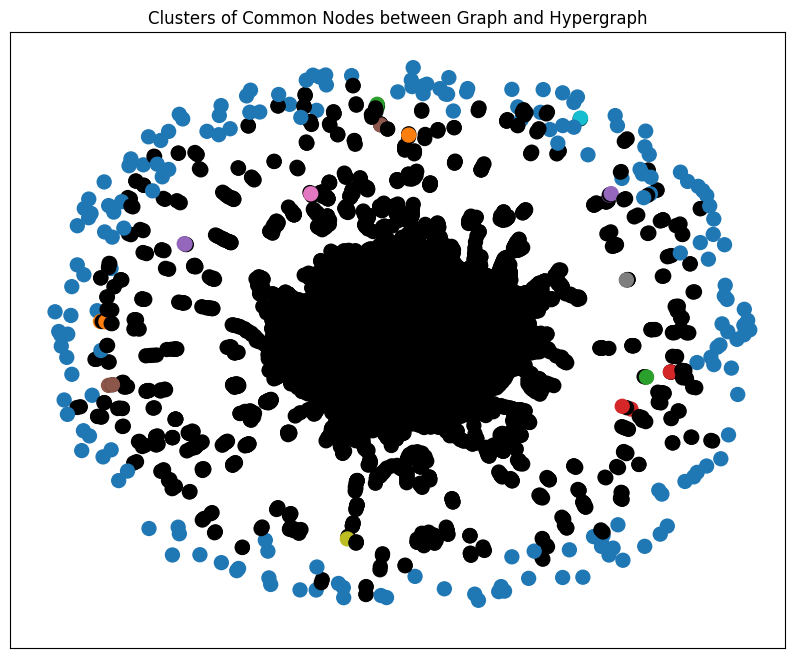

In [5]:
# Main function
def main():
    filename = '/kaggle/input/cse551/roadNet_Texas.txt'

    G, H = load_youtube_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    graph_partition = apply_louvain_on_graph(G)
    hypergraph_partition = apply_louvain_on_hypergraph(H)

    graph_communities = extract_communities(graph_partition)
    hypergraph_communities = extract_communities(hypergraph_partition, is_bipartite=True)

    common_nodes = find_common_nodes(graph_communities, hypergraph_communities)
    print(f"Number of common nodes between graph and hypergraph communities: {len(common_nodes)}")

    true_labels = [graph_partition[node] for node in common_nodes if node in graph_partition]
    pred_labels = [hypergraph_partition.get(f"node_{node}", -1) for node in common_nodes if f"node_{node}" in hypergraph_partition]

    calculate_evaluation_metrics(true_labels, pred_labels, graph_communities, hypergraph_communities)

    cluster_labels = cluster_and_visualize_common_nodes(common_nodes)

if __name__ == "__main__":
    main()


# ---------------------------------------------------------------------------

***Importing Libraries***

***500000 data***

In [ ]:
import networkx as nx
import hypernetx as hnx
import community as community_louvain  # For Louvain on graph
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score,
    homogeneity_score, completeness_score, v_measure_score
)
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
# Load YouTube network data as graph and hypergraph
def load_youtube_network_data(filename, max_edges=500000):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H


In [ ]:
# Apply Louvain on graph
def apply_louvain_on_graph(G):
    return community_louvain.best_partition(G)

# Apply Louvain on hypergraph via bipartite graph conversion
def apply_louvain_on_hypergraph(H):
    B = nx.Graph()
    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            B.add_edge(f"edge_{edge_id}", f"node_{node}")
    return community_louvain.best_partition(B)

In [ ]:
# Extract communities from partition dictionary
def extract_communities(partition, is_bipartite=False):
    communities = defaultdict(set)
    for node, community in partition.items():
        if is_bipartite and node.startswith("edge_"):
            continue
        actual_node = int(node.split('_')[1]) if is_bipartite and node.startswith("node_") else node
        communities[community].add(actual_node)
    return communities

# Find common nodes between graph and hypergraph communities
def find_common_nodes(graph_communities, hypergraph_communities):
    graph_nodes = set(node for nodes in graph_communities.values() for node in nodes)
    hypergraph_nodes = set(node for nodes in hypergraph_communities.values() for node in nodes)
    return graph_nodes & hypergraph_nodes

In [ ]:
# Custom Jaccard-based metrics
def jaccard(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def precision_Jaccard(reference, predicted, threshold=0.5):
    counter = 0
    for pred in predicted:
        for ref in reference:
            score = jaccard(set(ref), set(pred))
            if score >= threshold:
                counter += 1
                break
    return counter / float(len(predicted)) if len(predicted) > 0 else 0

def recall_Jaccard(reference, predicted, threshold=0.5):
    counter = 0
    for ref in reference:
        for pred in predicted:
            score = jaccard(set(ref), set(pred))
            if score >= threshold:
                counter += 1
                break
    return counter / float(len(reference)) if len(reference) > 0 else 0

def F_measure_Jaccard(reference, predicted, threshold=0.5):
    p = precision_Jaccard(reference, predicted, threshold)
    r = recall_Jaccard(reference, predicted, threshold)
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0


In [ ]:
# Calculate evaluation metrics
def calculate_evaluation_metrics(true_labels, pred_labels, graph_communities, hypergraph_communities):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    
    purity = np.sum(np.amax(contingency_matrix(true_labels, pred_labels), axis=0)) / len(true_labels)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")

    graph_community_list = list(graph_communities.values())
    hypergraph_community_list = list(hypergraph_communities.values())

    precision = precision_Jaccard(graph_community_list, hypergraph_community_list)
    recall = recall_Jaccard(graph_community_list, hypergraph_community_list)
    f1 = F_measure_Jaccard(graph_community_list, hypergraph_community_list)

    print(f"Precision (Jaccard): {precision:.4f}")
    print(f"Recall (Jaccard): {recall:.4f}")
    print(f"F1 Score (Jaccard): {f1:.4f}")

In [ ]:
# Cluster and visualize the common nodes
def cluster_and_visualize_common_nodes(common_nodes):
    G_common = nx.Graph()
    G_common.add_nodes_from(common_nodes)

    for node in common_nodes:
        neighbors = [n for n in common_nodes if abs(n - node) <= 5]
        G_common.add_edges_from((node, n) for n in neighbors if node != n)

    adjacency_matrix = nx.to_numpy_array(G_common)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(adjacency_matrix)
    labels = clustering.labels_

    # Group nodes by cluster labels
    clusters = defaultdict(list)
    for node, label in zip(common_nodes, labels):
        clusters[label].append(node)
    
    # Print clusters of common nodes
    for label, nodes in clusters.items():
        cluster_type = "Noise" if label == -1 else f"Cluster {label}"
        print(f"{cluster_type}: {nodes[:10]}...")  # Show first 10 nodes for brevity

    # Visualize clusters
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_common)
    colors = [f"C{label}" if label != -1 else 'black' for label in labels]

    nx.draw_networkx_nodes(G_common, pos, node_color=colors, node_size=100)
    nx.draw_networkx_edges(G_common, pos, alpha=0.5)
    plt.title("Clusters of Common Nodes between Graph and Hypergraph")
    plt.show()

    return labels

In [ ]:
# Main function
def main():
    filename = '/kaggle/input/cse551/roadNet_Texas.txt'

    G, H = load_youtube_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")

    graph_partition = apply_louvain_on_graph(G)
    hypergraph_partition = apply_louvain_on_hypergraph(H)

    graph_communities = extract_communities(graph_partition)
    hypergraph_communities = extract_communities(hypergraph_partition, is_bipartite=True)

    common_nodes = find_common_nodes(graph_communities, hypergraph_communities)
    print(f"Number of common nodes between graph and hypergraph communities: {len(common_nodes)}")

    true_labels = [graph_partition[node] for node in common_nodes if node in graph_partition]
    pred_labels = [hypergraph_partition.get(f"node_{node}", -1) for node in common_nodes if f"node_{node}" in hypergraph_partition]

    calculate_evaluation_metrics(true_labels, pred_labels, graph_communities, hypergraph_communities)

    cluster_labels = cluster_and_visualize_common_nodes(common_nodes)

if __name__ == "__main__":
    main()


Graph loaded with 182614 nodes and 251336 edges.
Hypergraph loaded with 180302 hyperedges.
Number of common nodes between graph and hypergraph communities: 125100
NMI: 0.6019
ARI: 0.0000
Purity: 1.0000
Homogeneity: 1.0000
Completeness: 0.4305
V-measure: 0.6019
Precision (Jaccard): 0.0007
Recall (Jaccard): 0.1938
F1 Score (Jaccard): 0.0014


# ---------------------------------------------------------------------------------------

# Using Louvian and Spectral clusturing

In [ ]:
import networkx as nx
import hypernetx as hnx
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    jaccard_score,
    f1_score,
    precision_score,
    recall_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict
import community as community_louvain
from sklearn.metrics.cluster import contingency_matrix


In [ ]:
# Step 1: Data Loading
def load_network_data(filename, max_edges=100000):
    G = nx.Graph()
    hyperedges = defaultdict(list)

    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            if i >= max_edges:
                break
            if not line.startswith('#'):
                nodes = list(map(int, line.strip().split()))
                u, v = nodes[0], nodes[1:]
                G.add_edges_from([(u, vi) for vi in v])
                hyperedges[u] = v

    H = hnx.Hypergraph(hyperedges)
    return G, H


# Step 2: Louvain Clustering on Graph
def louvain_clustering(G):
    return community_louvain.best_partition(G)


In [ ]:
# Step 3: Spectral Clustering on Hypergraph
def build_incidence_matrix(H):
    nodes = list(H.nodes)
    edges = list(H.edges)
    node_index = {node: i for i, node in enumerate(nodes)}
    edge_index = {edge: i for i, edge in enumerate(edges)}

    incidence_data = []
    row_indices = []
    col_indices = []

    for edge_id, nodes in H.incidence_dict.items():
        for node in nodes:
            if node in node_index:
                row_indices.append(node_index[node])
                col_indices.append(edge_index[edge_id])
                incidence_data.append(1)

    incidence_matrix = csr_matrix((incidence_data, (row_indices, col_indices)), shape=(len(H.nodes), len(H.edges)))
    return incidence_matrix


def hypergraph_spectral_clustering(H, num_clusters=5):
    nodes = list(H.nodes)
    incidence_matrix = build_incidence_matrix(H)
    adjacency = incidence_matrix @ incidence_matrix.T
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed')
    labels = spectral.fit_predict(adjacency.toarray())
    return {node: labels[i] for i, node in enumerate(nodes)}





In [ ]:
# Step 7: Visualize Clusters
def visualize_clusters(node_ids, labels):
    labels = np.array(labels).reshape(-1, 1)
    if labels.shape[1] < 2:
        print("Not enough dimensions for PCA. Plotting single feature as is.")
        plt.figure(figsize=(8, 4))
        plt.scatter(range(len(labels)), labels, c=labels.flatten(), cmap='viridis', alpha=0.8)
        plt.title("1D Visualization of Clusters for Common Nodes")
        plt.xlabel("Node Index")
        plt.ylabel("Cluster Label")
        plt.grid(True)
        plt.show()
    else:
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(labels)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels.flatten(), cmap='viridis', alpha=0.8)
        plt.title("Visualization of Clusters for Common Nodes")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.colorbar(scatter, label='Cluster Label')
        plt.grid(True)
        plt.show()

In [ ]:
# Step 4: Finding Common Nodes between Graph and Hypergraph Communities
def find_common_nodes(graph_partition, hypergraph_partition):
    common_nodes = {}
    for node, community in graph_partition.items():
        if node in hypergraph_partition:
            common_nodes[node] = (community, hypergraph_partition[node])
    return common_nodes


# Step 5: Clustering on Common Nodes
def cluster_common_nodes(common_nodes, num_clusters=3):
    if len(common_nodes) < num_clusters:
        print(f"Not enough nodes to form {num_clusters} clusters. Using {len(common_nodes)} clusters instead.")
        num_clusters = len(common_nodes)
    
    common_node_ids = list(common_nodes.keys())
    common_labels = np.array([val[0] for val in common_nodes.values()]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clustered_labels = kmeans.fit_predict(common_labels)
    return common_node_ids, clustered_labels

In [ ]:

# Step 6: Calculate and Print Evaluation Metrics
def evaluate_clustering_metrics(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    jaccard = jaccard_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    homogeneity = homogeneity_score(true_labels, pred_labels)
    completeness = completeness_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)

    # Calculate Purity
    contingency = contingency_matrix(true_labels, pred_labels)
    purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    print(f"NMI: {nmi:.4f}")
    print(f"ARI: {ari:.4f}")
    print(f"Jaccard Similarity Index: {jaccard:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Purity: {purity:.4f}")
    print(f"Homogeneity: {homogeneity:.4f}")
    print(f"Completeness: {completeness:.4f}")
    print(f"V-measure: {v_measure:.4f}")


Graph loaded with 37502 nodes and 50369 edges.
Hypergraph loaded with 36861 hyperedges.


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Number of common nodes: 25823
NMI: 0.0001
ARI: 0.0001
Jaccard Similarity Index: 0.0834
F1 Score: 0.1368
Precision: 0.1831
Recall: 0.1998
Purity: 0.7816
Homogeneity: 0.0001
Completeness: 0.0001
V-measure: 0.0001
Not enough dimensions for PCA. Plotting single feature as is.


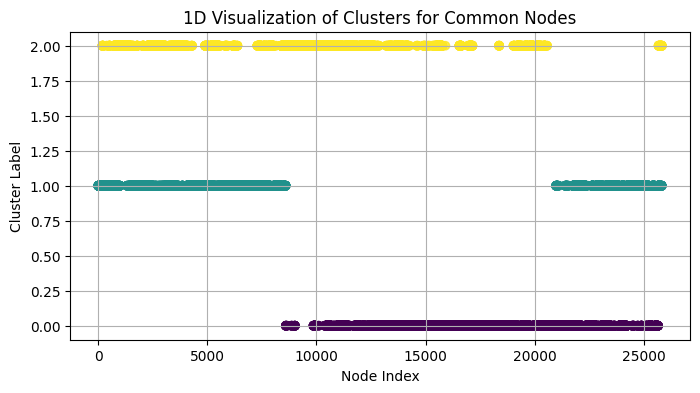

In [1]:
# Main Function
def main():
    filename = '/kaggle/input/cse551/roadNet_Texas.txt'
    
    # Step 1: Load Network Data
    G, H = load_network_data(filename)
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"Hypergraph loaded with {len(H.edges)} hyperedges.")
    
    # Step 2: Louvain Clustering on Graph
    graph_partition = louvain_clustering(G)
    
    # Step 3: Spectral Clustering on Hypergraph
    hypergraph_partition = hypergraph_spectral_clustering(H, num_clusters=5)
    
    # Step 4: Finding Common Nodes
    common_nodes = find_common_nodes(graph_partition, hypergraph_partition)
    print(f"Number of common nodes: {len(common_nodes)}")
    
    # Step 5: Cluster on Common Nodes
    if len(common_nodes) > 0:
        common_node_ids, common_labels = cluster_common_nodes(common_nodes, num_clusters=3)
        
        # Step 6: Evaluate Clustering
        true_labels = [val[1] for val in common_nodes.values()]
        evaluate_clustering_metrics(true_labels, common_labels)
        
        # Step 7: Visualize Clusters
        visualize_clusters(common_node_ids, common_labels)
    else:
        print("No common nodes to cluster and visualize.")


if __name__ == "__main__":
    main()
